# Valley scale vertical velocity variance and wind profiles

Figure in manuscript

Produced by Daniel Hogan

## Imports

In [1]:
# general
import os
os.chdir('/home/dlhogan/GitHub/Synoptic-Sublimation')
import datetime as dt
import json
import glob
# data 
import xarray as xr 
import numpy as np
import pandas as pd
from scipy import stats as stats 
# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# helper tools
from utils.get_sail_data import get_sail_data
from utils.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import utils.helper_funcs as hf
from metpy import calc
from metpy.units import units

nctoolkit is using Climate Data Operators version 2.4.4


## Data

### Sublimation Events

In [2]:
# First, gather the dates during the long sublimation events
long_sub_events_22 = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
long_sub_events_23 = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
# concatenate the two dataframes
long_sub_events = pd.concat([long_sub_events_22, long_sub_events_23])

# Next, grab short duration intense sublimation events
short_sub_events_22 = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)
short_sub_events_23 = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)
# concatenate the two dataframes
short_sub_events = pd.concat([short_sub_events_22, short_sub_events_23])

In [3]:
long_sub_events_22_start = long_sub_events_22.reset_index().groupby('event').first()['index']
long_sub_events_22_end = long_sub_events_22.reset_index().groupby('event').last()['index']
short_sub_events_22_start = short_sub_events_22.reset_index().groupby('event').first()['index']
short_sub_events_22_end = short_sub_events_22.reset_index().groupby('event').last()['index']
# get the start and end datetimes of the events
long_sub_events_23_start = long_sub_events_23.reset_index().groupby('event').first()['time']
long_sub_events_23_end = long_sub_events_23.reset_index().groupby('event').last()['time']
short_sub_events_23_start = short_sub_events_23.reset_index().groupby('event').first()['time']
short_sub_events_23_end = short_sub_events_23.reset_index().groupby('event').last()['time']

In [4]:
# make 10 minute interval time series ofr each event
def get_event_times(event_start, event_end, freq='10T'):
    event_times = []
    for event in event_start.index.unique():
        start = event_start.loc[event]
        end = event_end.loc[event]
        time = pd.date_range(start, end, freq=freq)
        event_times.append(time)
    return pd.Series(np.concatenate(event_times))

# get the 10 minute time series for each event
w22_long_events_10min = get_event_times(long_sub_events_22_start, long_sub_events_22_end)
w22_short_events_10min = get_event_times(short_sub_events_22_start, short_sub_events_22_end)
w23_long_events_10min = get_event_times(long_sub_events_23_start, long_sub_events_23_end)
w23_short_events_10min = get_event_times(short_sub_events_23_start, short_sub_events_23_end)

### Vertical Velocity Variance

In [5]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

In [6]:
# establish start and ends of the different winters
start_22, end_22 = dt.datetime(2021, 12, 1), dt.datetime(2022, 3, 31)
start_23, end_23 = dt.datetime(2022, 12, 1), dt.datetime(2023, 3, 31)

In [7]:
sail_datastream= "gucdlprofwstats4newsM1.c1"
storage_directory = '/home/dlhogan/GitHub/Synoptic-Sublimation/01_data/processed_data/sail/gucdlprofwstats'
# create empty data dictionary
data_loc_dict = {}

def download_wstats_data(sail_datastream, start, end, storage_directory):
        if (os.path.exists(f"{storage_directory}/{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")): 
                print(f"{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc already exists")
                print('-------------------')
                # add the filename to the dictionary which can be used if we want to load the data
                wstats_data = xr.open_dataset(os.path.join(storage_directory,f"{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc"))
        else:
                wstats_data = get_sail_data(api_username,
                                                api_token,
                                                sail_datastream,
                                                startdate=start.strftime('%Y%m%d'),
                                                enddate=end.strftime('%Y%m%d'))
                wstats_data.to_netcdf(f"{storage_directory}/{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")
        return wstats_data

w22_wstats_data = download_wstats_data(sail_datastream, start_22, end_22, storage_directory)
w23_wstats_data = download_wstats_data(sail_datastream, start_23, end_23, storage_directory)

device_alt = w22_wstats_data['alt'].values[0]

gucdlprofwstats4newsM1_20211201_20220331.nc already exists
-------------------
gucdlprofwstats4newsM1_20221201_20230331.nc already exists
-------------------


### Wind Speed and Direction

In [8]:
files_22 = glob.glob('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/*')
files_23 = glob.glob('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/radiosonde/*')
# create a function to get specific soundin data
# we want to grab the values when pressure is closest to 700, 650, 600, 550, 500, 450, 400, 350, and 300 hPa
# We then want to calculate the time offset from the start time of the sounding and then combine this into a new dataset
# with coordinates of inital time, and pressure level
# and variables of temperature, dewpoint, wind speed, wind direction, rh, and height etc
def get_sounding_height_data(ds):
    # get the start time of the sounding
    start_time = pd.to_datetime(ds.time.values[0])
    # round to either 00Z or 12Z
    if (start_time.hour < 6) | (start_time.hour > 18):
        start_time = start_time.replace(hour=0, minute=0, second=0)
    else:
        start_time = start_time.replace(hour=12, minute=0, second=0)
    # get the time delta of every other measurement
    time_delta = ds.time.values - ds.time.values[0]
    # get the pressure levels we want
    pressure_levels = [700, 650, 600, 550, 500, 450, 400, 350, 300]
    # create a dictionary to hold the data
    data = {}
    # loop through the pressure levels
    for p in pressure_levels:
        # get the index of the pressure level
        idx = np.argmin(np.abs(ds.pres.values - p))
        # get the time offset convert to hours
        time_offset = time_delta[idx].astype('timedelta64[s]').astype('timedelta64[m]')
        # get the data
        data[p] = {'time_offset': time_offset,
                   'pressure': ds.pres.values[idx],
                   'tdry': ds.tdry.values[idx],
                   'dp': ds.dp.values[idx],
                   'u_wind': ds.u_wind.values[idx],
                   'v_wind': ds.v_wind.values[idx],
                   'wspd': ds.wspd.values[idx],
                   'deg': ds.deg.values[idx],
                   'rh': ds.rh.values[idx],
                   'alt': ds.alt.values[idx]}
    # create a dataframe
    df = pd.DataFrame(data).T
    # add the start time
    df['start_time'] = start_time

    # convert to xarray and make start_time and coordinate
    df = df.reset_index().rename(columns={'index': 'pres'})
    df['pres'] = df['pres'].astype('int')
    df = df.set_index(['start_time', 'pres'])

    return df

## Data Processing

### Vertical Velocity Variance

In [9]:
def filter_wstats_data(wstats_data, heights=None, variables=None, localize_time=False, add_time_grouper=True):
    # write a docstring for the function
    """
    This function filters the wstats data to only include the heights and variables specified.
    """
    # Filter data for SNR extremes
    wstats_data_filtered = wstats_data.where((wstats_data.snr > 0.008) & (wstats_data.noise < 1))
    
    # filter the data by height and variables
    if heights is None:
        pass
    else:
        wstats_data_filtered = wstats_data_filtered.sel(height=heights)  
    if variables is None:
        pass
    else:
        wstats_data_filtered = wstats_data_filtered[variables]
    if localize_time:
        wstats_data_filtered['time'] = pd.to_datetime(wstats_data_filtered.time).tz_localize('UTC').tz_convert('US/Mountain').tz_localize(None)
    else:
        pass
    if add_time_grouper:
        # I want to group by individual 10-minute periods to average over the dataset.
        # let's create a new array that indexes what 10-minute period each time belongs to
        # first, create an array of each 10-minute period
        index_array = np.arange(0,24*6,1)
        # then, create an array of the time values
        time_range = pd.date_range("2022-12-01", "2022-12-02", freq='10min').time
        # then, create a dictionary that maps the time values to the index array
        time_index= pd.Series(dict(zip(time_range, index_array)))
        # then, create a new array that maps the time values to the index array
        # inefficient, but it works, can I make it faster?
        # time_index_array = np.array([time_index_dict[time.dt.time.item()] for time in wstats_data_filtered.time])
        time_index_array = time_index.loc[wstats_data_filtered.time.dt.time].values
        wstats_data_filtered = wstats_data_filtered.assign(time_index=('time', time_index_array))
    else:
        pass
    return wstats_data_filtered

# filter the data to only include the heights and variables we want
w22_wstats_data_filtered = filter_wstats_data(w22_wstats_data, heights=slice(0,2000), variables=['snr','w','w_variance','w_skewness','noise','ecor_w_var','ecor_w_skew'], localize_time=False, add_time_grouper=True)
w23_wstats_data_filtered = filter_wstats_data(w23_wstats_data, heights=slice(0,2000), variables=['snr','w','w_variance','w_skewness','noise','ecor_w_var','ecor_w_skew'], localize_time=False, add_time_grouper=True)

# add device_alt to the height variable
w22_wstats_data_filtered['height'] = w22_wstats_data_filtered['height'] + device_alt
w23_wstats_data_filtered['height'] = w23_wstats_data_filtered['height'] + device_alt
# convert to dataframe, may not use
# wstats_df = utils.modify_df_timezone(wstats_data.to_dataframe().reset_index(), 'UTC', 'US/Mountain')
# wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
# wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
# wstats_df['height_low'] = wstats_df['height'] - 15
# wstats_df['height_high'] = wstats_df['height'] + 15


#### 2022 VVV statistic

In [10]:
w22_daily_stats = w22_wstats_data_filtered.groupby('time_index').mean()
w22_daily_stats_no_events = w22_wstats_data_filtered.sel(time=w22_wstats_data_filtered.time[~w22_wstats_data_filtered.time.isin(np.concatenate([w22_long_events_10min.values,
                                                                                                                                                w22_short_events_10min.values]))]).groupby('time_index').mean()
w22_daily_stats_long_events = w22_wstats_data_filtered.sel(time=w22_long_events_10min.values).groupby('time_index').mean()
w22_daily_stats_short_events = w22_wstats_data_filtered.sel(time=w22_short_events_10min.values).groupby('time_index').mean()

# Get avearage over 100 meter bins for the whole winter
w22_height_stats = w22_wstats_data_filtered.sel(time=w22_wstats_data_filtered.time[~w22_wstats_data_filtered.time.isin(np.concatenate([w22_long_events_10min.values,
                                                                                                                                                w22_short_events_10min.values]))]).groupby_bins('height', bins=np.arange(device_alt,device_alt+2000,90)).mean()
# Get average over 100 meter bins for the long events
w22_height_stats_long_events = w22_wstats_data_filtered.sel(time=w22_long_events_10min.values).groupby_bins('height', bins=np.arange(device_alt,device_alt+2000,90)).mean()
# Get average over 100 meter bins for the short events
w22_height_stats_short_events = w22_wstats_data_filtered.sel(time=w22_short_events_10min.values).groupby_bins('height', bins=np.arange(device_alt,device_alt+2000,90)).mean()

In [11]:
# reset the index and convert to dataframe
w22_height_stats_df = w22_height_stats.to_dataframe().reset_index()
w22_height_stats_long_events_df = w22_height_stats_long_events.to_dataframe().reset_index()
w22_height_stats_short_events_df = w22_height_stats_short_events.to_dataframe().reset_index()

# replace height_bins with the left of the bin
w22_height_stats_df['height'] = w22_height_stats_df['height_bins'].apply(lambda x: x.left)
w22_height_stats_long_events_df['height'] = w22_height_stats_long_events_df['height_bins'].apply(lambda x: x.left)
w22_height_stats_short_events_df['height'] = w22_height_stats_short_events_df['height_bins'].apply(lambda x: x.left)


#### 2023 VVV statistic

In [12]:
w23_daily_stats = w23_wstats_data_filtered.groupby('time_index').mean()
w23_daily_stats_no_events = w23_wstats_data_filtered.sel(time=w23_wstats_data_filtered.time[~w23_wstats_data_filtered.time.isin(np.concatenate([w23_long_events_10min.values,
                                                                                                                                                w23_short_events_10min.values]))]).groupby('time_index').mean()
w23_daily_stats_long_events = w23_wstats_data_filtered.sel(time=w23_long_events_10min.values).groupby('time_index').mean()
w23_daily_stats_short_events = w23_wstats_data_filtered.sel(time=w23_short_events_10min.values).groupby('time_index').mean()

# Get avearage over 100 meter bins for the whole winter
w23_height_stats = w23_wstats_data_filtered.sel(time=w23_wstats_data_filtered.time[~w23_wstats_data_filtered.time.isin(np.concatenate([w23_long_events_10min.values,
                                                                                                                                                w23_short_events_10min.values]))]).groupby_bins('height', bins=np.arange(device_alt,device_alt+2000,90)).mean()
# Get average over 100 meter bins for the long events
w23_height_stats_long_events = w23_wstats_data_filtered.sel(time=w23_long_events_10min.values).groupby_bins('height', bins=np.arange(device_alt,device_alt+2000,90)).mean()
# Get average over 100 meter bins for the short events
w23_height_stats_short_events = w23_wstats_data_filtered.sel(time=w23_short_events_10min.values).groupby_bins('height', bins=np.arange(device_alt,device_alt+2000,90)).mean()

In [13]:
# reset the index and convert to dataframe
w23_height_stats_df = w23_height_stats.to_dataframe().reset_index()
w23_height_stats_long_events_df = w23_height_stats_long_events.to_dataframe().reset_index()
w23_height_stats_short_events_df = w23_height_stats_short_events.to_dataframe().reset_index()

# replace height_bins with the left of the bin
w23_height_stats_df['height'] = w23_height_stats_df['height_bins'].apply(lambda x: x.left)
w23_height_stats_long_events_df['height'] = w23_height_stats_long_events_df['height_bins'].apply(lambda x: x.left)
w23_height_stats_short_events_df['height'] = w23_height_stats_short_events_df['height_bins'].apply(lambda x: x.left)


#### Combine data

In [14]:
cdf_all = pd.concat([w22_height_stats_df, w23_height_stats_df]).reset_index()
cdf_long_events = pd.concat([w22_height_stats_long_events_df, w23_height_stats_long_events_df]).reset_index()
cdf_short_events = pd.concat([w22_height_stats_short_events_df, w23_height_stats_short_events_df]).reset_index()

### Wind Speed and Direction

In [69]:
# create a function to calculate wind direction from u and v wind components
def calculate_wind_direction(u, v):
    """
    Calculate wind direction from u and v wind components.
    Wind direction is defined as the direction from which the wind is coming.
    """
    wind_dir = 270 - np.arctan2(v, u) * (180 / np.pi)  # Convert radians to degrees
    wind_dir = (wind_dir) % 360  # Ensure wind direction is in [0, 360)
    return wind_dir

def get_sounding_winds(ds):
    # Filter to only include data below 5000 m
    df = ds[['pres','wspd','u_wind', 'v_wind','alt']].where(ds['alt'] < 5000, drop=True).to_dataframe().reset_index(drop=True)

    # Get the time value
    time = pd.to_datetime(ds.time.values[0])

    # Group by 50 m altitude bins
    df_grouped = df.groupby(pd.cut(df.alt, np.arange(df.alt.min() - 100, df.alt.max(), 100)), observed=True).mean().reset_index(drop=True)
    
    # Limit to first 30 bins
    df_grouped = df_grouped.iloc[:30].copy()
    df_grouped["alt_bin"] = np.arange(df_grouped.shape[0])
    df_grouped = df_grouped.set_index("alt_bin")

    # Convert to xarray Dataset
    ds_out = xr.Dataset.from_dataframe(df_grouped)

    # Add time dimension
    ds_out = ds_out.expand_dims(dim={"time": [time]})

    return ds_out

# Example usage
ds = xr.open_dataset(files_23[397])
sounding_xr = get_sounding_winds(ds)


#### 2022 sounding data

In [70]:
data = {}
for i, f in enumerate(files_22):
    try:
        ds = xr.open_dataset(f)
        # get the sounding data
        data[f] = get_sounding_winds(ds)
        # replace the index with the first timestep of the ds
    except:
        print(f'Error with {f}')
        continue

# Combine all data into single dataset concatenating along the time dimension
sounding_ds_22 = xr.concat(list(data.values()), dim='time')

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220817.113900.cdf


#### 2023 sounding data

In [71]:
data = {}
for i, f in enumerate(files_23):
    try:
        ds = xr.open_dataset(f)
        # get the sounding data
        data[f] = get_sounding_winds(ds)
        # replace the index with the first timestep of the ds
    except:
        print(f'Error with {f}')
        continue

# Combine all data into single dataset concatenating along the time dimension
sounding_ds_23 = xr.concat(list(data.values()), dim='time')

#### Combine the two datasets

In [72]:
# combine the two datasets
wind_sounding_ds = xr.concat([sounding_ds_22, sounding_ds_23], dim='time')

# get DJFM month data
winter_wind_sounding_ds = wind_sounding_ds.sel(time=wind_sounding_ds.time.dt.month.isin([12, 1, 2, 3]))

# limit to only the winter soundings (time between 23 and 01 hours)
pm_winter_wind_sounding_ds = winter_wind_sounding_ds.sel(time=((winter_wind_sounding_ds.time.dt.hour > 20) | (winter_wind_sounding_ds.time.dt.hour < 3)))

# isolate soundings that occurred on the days of long sublimation events
long_sub_pm_wind_sounding_ds = pm_winter_wind_sounding_ds.sel(time=pm_winter_wind_sounding_ds.time.dt.date.isin(long_sub_events.index.date))

# isolate soundings that occurred on the days of short sublimation events
short_sub_pm_wind_sounding_ds = pm_winter_wind_sounding_ds.sel(time=pm_winter_wind_sounding_ds.time.dt.date.isin(short_sub_events.index.date))

# exclude soundings that occurred on the days of long sublimation events from pm_winter_wind_sounding_ds
no_sub_pm_wind_sounding_ds = pm_winter_wind_sounding_ds.sel(time=(~pm_winter_wind_sounding_ds.time.dt.date.isin(long_sub_events.index.date))
                                                             & (~pm_winter_wind_sounding_ds.time.dt.date.isin(short_sub_events.index.date)))

In [73]:
# close sounding_ds_22 and sounding_ds_23 to free up memory
sounding_ds_22.close()
sounding_ds_23.close()

#### Calculate wind direcation

In [20]:
# add wind direction to the datasets
long_sub_pm_wind_sounding_ds['deg'] = calculate_wind_direction(long_sub_pm_wind_sounding_ds['u_wind'], long_sub_pm_wind_sounding_ds['v_wind'])
short_sub_pm_wind_sounding_ds['deg'] = calculate_wind_direction(short_sub_pm_wind_sounding_ds['u_wind'], short_sub_pm_wind_sounding_ds['v_wind'])
no_sub_pm_wind_sounding_ds['deg'] = calculate_wind_direction(no_sub_pm_wind_sounding_ds['u_wind'], no_sub_pm_wind_sounding_ds['v_wind'])

## Figure

Text(0.4, 0.54, 'Mean Ridgeline\nElevation')

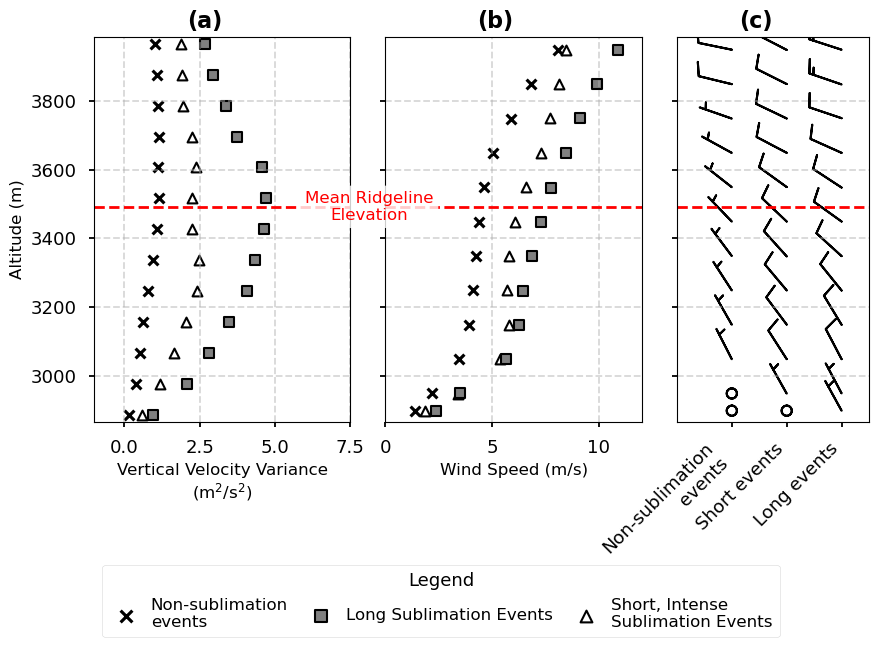

In [115]:
plt.style.use('seaborn-v0_8-talk')

# Set up the figure and gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[2, 2, 1.5], figure=fig)

# reduce whitespace between subplots
gs.update(wspace=0.15)

### Plot setup ###
# Create subplots with shared y-axis
ax_vvv = fig.add_subplot(gs[0])
ax_spd = fig.add_subplot(gs[1])
ax_barbs = fig.add_subplot(gs[2])

# set y-axis ticks and label color to none
ax_spd.tick_params(axis='y', labelcolor='none')
ax_barbs.tick_params(axis='y', labelcolor='none')

# add gridlines to each subplot
ax_vvv.grid(axis='both', linestyle='--', alpha=0.5)
ax_spd.grid(axis='both', linestyle='--', alpha=0.5)
ax_barbs.grid(axis='y', linestyle='--', alpha=0.5)

# Plot vertical velocity variance
# Entire Winter
ax_vvv.scatter(cdf_all['w_variance'].groupby(cdf_all['height']).mean(),
                 np.arange(device_alt, device_alt+1980,90),
                 marker='x',
                 facecolor='black',
                 s=50,
                 label='Non-sublimation\nevents',)

# Long events
ax_vvv.scatter(cdf_long_events['w_variance'].groupby(cdf_long_events['height']).mean(),
                 np.arange(device_alt, device_alt+1980,90),
                 marker='s',
                 edgecolor='black',
                 facecolor='grey',
                 s=50,
                 lw=1.5,
                 label='Long Sublimation Events',)

# Short events
ax_vvv.scatter(cdf_short_events['w_variance'].groupby(cdf_short_events['height']).mean(),
                 np.arange(device_alt, device_alt+1980,90),
                 marker='^',
                 edgecolor='black',
                 facecolor='white',
                 s=50,
                 lw=1.5,
                 label='Short, Intense\nSublimation Events',)

# add observational points as x's ecor_w_var for each period
# mean_obs_all = w23_wstats_data_filtered['ecor_w_var'].sel(time=w23_wstats_data_filtered.time[~w23_wstats_data_filtered.time.isin(np.concatenate([w23_long_events_10min.values,   
#                                                                                                                                                 w23_short_events_10min.values]))]).mean()
# mean_obs_long = w23_wstats_data_filtered['ecor_w_var'].sel(time=w23_long_events_10min.values).mean()
# mean_obs_short = w23_wstats_data_filtered['ecor_w_var'].sel(time=w23_short_events_10min.values).mean()
# print([mean_obs_all, mean_obs_long, mean_obs_short])
# ax_vvv.scatter(mean_obs_all, 0, marker='x', facecolor='black', edgecolor='black', s=100, )
# ax_vvv.scatter(mean_obs_long, 0, marker='s', facecolor='grey', edgecolor='black', s=100, )
# ax_vvv.scatter(mean_obs_short, 0, marker='^', facecolor='white', edgecolor='black', s=100, alpha=0.5)

ax_vvv.set_xlabel('Vertical Velocity Variance\n(m$^2$/s$^2$)')
ax_vvv.set_ylabel('Altitude (m)', fontsize=12)
ax_vvv.set_xlim(-1,7.5)

# Define categories
categories = [
    ("Non-sublimation\nevents", no_sub_pm_wind_sounding_ds, 0, 'o'),
    ("Short events", short_sub_pm_wind_sounding_ds, 1, '^'),
    ("Long events", long_sub_pm_wind_sounding_ds, 2, 's'),
]

# LEFT PLOT: Wind spdection (white-filled markers)
# Plot the mean wind speed profile for each category
ax_spd.scatter(no_sub_pm_wind_sounding_ds['wspd'].mean(dim='time'),
                no_sub_pm_wind_sounding_ds['alt'].mean(dim='time'), 
                label='Non-sublimation\nevents', 
                marker='x',
                facecolor='black',
                s=50,)
ax_spd.scatter(short_sub_pm_wind_sounding_ds['wspd'].mean(dim='time'),
              short_sub_pm_wind_sounding_ds['alt'].mean(dim='time'), 
              label='Short Events', 
              color='white',
              edgecolor='black',
              s=50,
              lw=1.5,
              marker='^')
ax_spd.scatter(long_sub_pm_wind_sounding_ds['wspd'].mean(dim='time'),
              long_sub_pm_wind_sounding_ds['alt'].mean(dim='time'), 
              label='Long Events', 
              color='grey',
              edgecolor='black',
              s=50,
              lw=1.5,
              marker='s')

ax_spd.set_xlabel('Wind Speed (m/s)')
ax_spd.set_xlim(0, 12)

# RIGHT PLOT: Wind Barbs
for label, ds, x_pos, marker in categories:
    u = ds['u_wind'].mean(dim='time').values[0:12]
    v = ds['v_wind'].mean(dim='time').values[0:12]
    alt = ds['alt'].mean(dim='time').values[0:12]
    x = np.ones_like(alt) * x_pos

    ax_barbs.barbs(
        x, alt, u, v,
        length=7,
        lw=1.5,
        barb_increments=dict(half=2.5, full=5, flag=25)
    )

# Format RIGHT plot
ax_barbs.set_xticks([0, 1, 2])
ax_barbs.set_xticklabels([c[0] for c in categories], rotation=45, ha='right', va='top')
ax_barbs.set_xlim(-1, 2.5)

### Legend setup ###
# Add the legend to below the left plot
ax_vvv.legend(loc='upper left', 
              bbox_to_anchor=(0, -0.35), 
              ncol=3, 
              fontsize=12, 
              frameon=True, 
              title='Legend', 
              title_fontsize='13', 
              handletextpad=0.5, 
              columnspacing=1.0, 
              markerscale=1.2)

### Titles and y-lim ###
title = ['(a)', '(b)', '(c)']
for i, ax in enumerate([ax_vvv, ax_spd, ax_barbs]):
    ax.set_ylim(device_alt-20,device_alt+1100)
    # add a bold (a) and (b) labels to the top left of each subplot
    ax.text(0.5, 1.07, title[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    # Add a red dashed line at 3505 m on both plots
    ax.axhline(device_alt+605, color='red', linestyle='--', linewidth=2,)
    # set x-axis label font size to 12
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)

# Add annotation to the figure
fig.text(0.4, 0.54, 'Mean Ridgeline\nElevation', 
            fontsize=12, ha='center', va='center', color='red',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.3'))

## Save Figure

In [117]:
save_location = '/home/dlhogan/GitHub/Synoptic-Sublimation/04_products/figures/draft/valley_scale_vvv_and_wind_profiles.png'

fig.savefig(save_location, bbox_inches='tight', dpi=300)